### CITS4404 Practical Project

# Camo Worms!

<div style="margin-left: 0px">
    &nbsp;
    <img src="velvet-worms.jpg" width=600>
    <br>
    <br>
</div>

Australian _velvet worms_ come in many colours, possibly as a camouflage function ([Current Biology](https://www.cell.com/current-biology/comments/S0960-9822(11)00208-9)).



In [3]:
# Imports

import numpy as np
import imageio.v3 as iio

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier
from sklearn.metrics.pairwise import euclidean_distances

rng = np.random.default_rng()
Path = mpath.Path
mpl.rcParams['figure.dpi']= 72 #size of images


In [4]:
# Global variables

IMAGE_DIR = 'images'
IMAGE_NAME='original'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


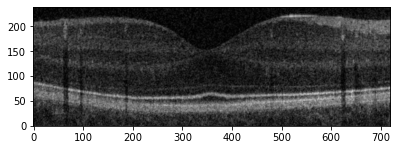

In [5]:
# Read, crop and display image and stats

def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

In [6]:
class Camo_Worm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour
        p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        p1 = [self.x + self.dr * np.cos(self.theta+self.dgamma), self.y + self.dr * np.sin(self.theta+self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1,p2]))

    def control_points (self):
        return self.bezier.control_points

    def path (self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch (self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width, capstyle='round')

    def intermediate_points (self, intervals=None):
        if intervals is None:
            intervals = max(3, int(np.ceil(self.r/8)))
        return self.bezier.point_at_t(np.linspace(0,1,intervals))

    def approx_length (self):
        intermediates = intermediate_points(self)
        eds = euclidean_distances(intermediates,intermediates)
        return np.sum(np.diag(eds,1))

    def colour_at_t(self, t, image):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        colours = [image[point[0],point[1]] for point in intermediates]
        return(np.array(colours)/255)


In [7]:
class Drawing:
    def __init__ (self, image):
        self.fig, self.ax = plt.subplots()
        self.image = image
        self.im = self.ax.imshow(self.image, cmap='gray', origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms):
        try:
            self.add_patches([w.patch() for w in worms])
        except TypeError:
            self.add_patches([worms.patch()])

    def show(self, save=None):
        if save is not None:
            plt.savefig(save)
        plt.show()


In [8]:
# Example of a random worm. You may do this differently.

    # centre points, angles and colour chosen from uniform distributions
    # lengths chosen from normal distributions with two std parameters passed
    # width chosen from gamma distribution with shape parameter 3 and scale passed

def random_worm (imshape, init_params):
    (radius_std, deviation_std, width_theta) = init_params
    (ylim, xlim) = imshape
    midx = xlim * rng.random()
    midy = ylim * rng.random()
    r = radius_std * np.abs(rng.standard_normal())
    theta = rng.random() * np.pi
    dr = deviation_std * np.abs(rng.standard_normal())
    dgamma = rng.random() * np.pi
    colour = rng.random()
    width = width_theta * rng.standard_gamma(3)
    return Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour)


In [9]:
# Initialise a random clew

def initialise_clew (size, imshape, init_params):
    clew = []
    for i in range(size):
        clew.append(random_worm(imshape, init_params))
    return clew

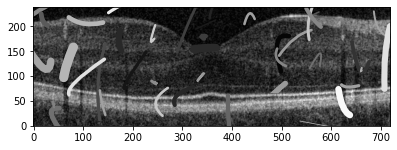

In [10]:
# Initialise clew of 40 and draw

clew = initialise_clew(40, image.shape, (40, 30, 1))
drawing = Drawing(image)
drawing.add_worms(clew)
drawing.show()

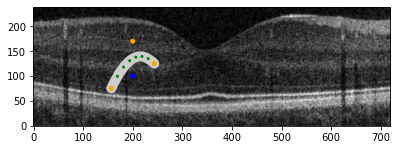

In [11]:
# Draw a single worm along with control points and some sample points

worm = Camo_Worm(200, 100, 50, np.pi/6, 70, np.pi/3, 10, 0.8)
drawing = Drawing(image)
drawing.add_worms(worm)
drawing.add_dots(worm.intermediate_points(8), radius=2, color='green')
drawing.add_dots(worm.control_points(),color='orange')
drawing.add_dots((200,100), color='blue')

drawing.show(save='bezier.png')

&copy; Cara MacNish, UWA, 2024



# ------------------------------------------------------------------------------

# Distance between worms

In [12]:
import matplotlib.colors as mcolors

In [13]:
# Initialise clew
clew = initialise_clew(3, image.shape, (40, 30, 1))

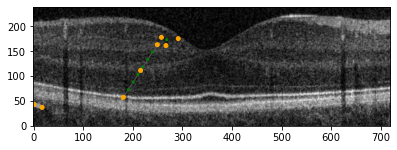

In [14]:
# Draw
drawing = Drawing(image)
drawing.add_worms(clew)
for worm in clew:
    drawing.add_dots(worm.intermediate_points(), radius=2, color='green')
    drawing.add_dots(worm.control_points(),color='orange')
drawing.show()

In [15]:
# Make list of intermediade points + extrema control points (not the middle point) for each worm
all_points = []
for i in range(len(clew)):
    all_points.append(list(np.vstack((clew[i].control_points()[0],clew[i].control_points()[2],clew[i].intermediate_points()))))

In [16]:
# matrix for shortest distances
D = np.zeros((len(clew),len(clew)))
# dict for points that have the shortest distance
shortest_distance = dict(zip(list(np.arange(len(clew))),[ [] for _ in range(len(clew)) ]))

# loop through all worms (but the last)
for m in range(len(clew)-1):
    # loop throug all remaining worms
    for n in range(m+1,len(clew)):
        dist = 100000
        # loop through all points in worm m
        for i in all_points[m]:
            # loop through all points in worm n
            for j in all_points[n]:
                dist_temp = np.linalg.norm(i-j) # calculate eucledian distance
                if dist_temp < dist:
                    dist = dist_temp # update distance variable if this distance is shorter

                    D[m][n] = dist # append shortest distance to matrix
                    p = (i,j) # save the two points
                
        shortest_distance[m].append(p) # append the points to dict

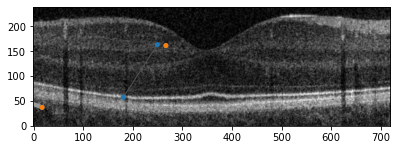

In [17]:
# draw the points
colors = list(mcolors.TABLEAU_COLORS.keys())
drawing = Drawing(image)
drawing.add_worms(clew)
for i in range(len(shortest_distance)):
    for j in range(len(shortest_distance[i])):
        drawing.add_dots((shortest_distance[i][j][0],shortest_distance[i][j][1]),color=colors[i])

drawing.show()

## Make circular mask and find image intensity

In [18]:
clew = initialise_clew(5, image.shape, (40, 30, 1))

In [19]:
### The following function is inspired by answers given on this page:
# https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array

def circular_mask(image,center,radius):
    # get image dimensions
    h = image.shape[1]
    w = image.shape[0]

    # create matrix with same shape as image and elements being the distance from the center point
    Y, X = np.ogrid[:w, :h]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    # create mask. True in pixels that are closer than the radius to the center. False everywhere else
    mask = dist_from_center <= radius
    return mask

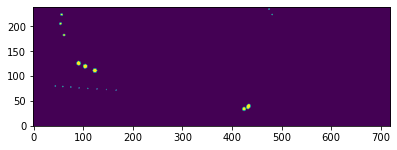

In [20]:
# create a masked image for clew
masked_img = np.zeros([image.shape[0],image.shape[1]]).astype(int)
# create a string to store mean intensity and standard variation for each worm
worm_intensities = []

for worm in clew: # loop through worms in clew
    masked_img_worm = np.zeros([image.shape[0],image.shape[1]]).astype(int) # initialize mask with zeros
    for i in range(len(worm.intermediate_points())): # loop through intermediate points in worm
        mask = circular_mask(image,[worm.intermediate_points()[i][0],worm.intermediate_points()[i][1]],worm.width) # make circular mask
        masked_img[mask] = int(1) # change mask intensity to 1
    
    masked_img_worm = masked_img # mask for each worm
    worm_intensities.append((np.mean(image * masked_img_worm), np.std((image * masked_img_worm)[(image * masked_img_worm)>0]))) # update values

# calculate mean intensity and standard deviation for the entire clew        
clew_intensities = (np.mean(image * masked_img), np.std((image * masked_img)[(image * masked_img)>0]))

# plot mask
plt.imshow(masked_img)
plt.gca().invert_yaxis()

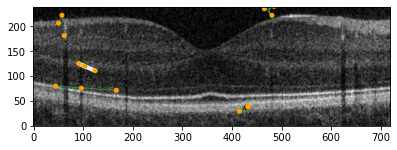

In [21]:
# Draw
drawing = Drawing(image)
drawing.add_worms(clew)
for worm in clew:
    drawing.add_dots(worm.intermediate_points(), radius=2, color='green')
    drawing.add_dots(worm.control_points(),color='orange')
drawing.show()

In [22]:
## ALTERNATIVELY

In [23]:
worm = random_worm(image.shape, (40, 30, 1))

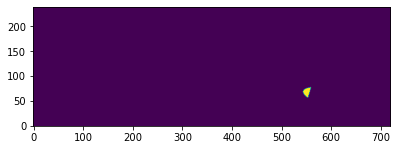

In [24]:
width, height=image.shape[0],image.shape[1]

poly_path=worm.path()

x, y = np.mgrid[:height, :width]
coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1))) # coors.shape is (4000000,2)

mask = poly_path.contains_points(coors)
plt.imshow(mask.reshape(height, width).T)
plt.gca().invert_yaxis()

plt.show()


In [25]:
mask.reshape(height, width).T

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

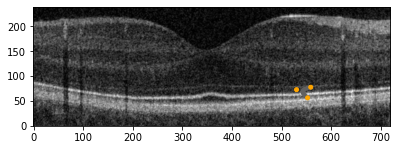

In [26]:
# draw the points
#colors = list(mcolors.TABLEAU_COLORS.keys())
drawing = Drawing(image)
drawing.add_worms(worm)
drawing.add_dots(worm.control_points(),color='orange')

drawing.show()

## Metrics

In [59]:
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
import cv2
import statistics

In [30]:
# Global variables

IMAGE_DIR = 'images'
IMAGE_NAME='averaged'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax

Image name (shape) (intensity max, min, mean, std)

averaged (240, 720) (182, 5, 49.4, 32.4)


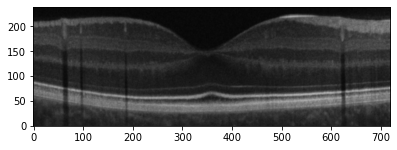

In [31]:
# Read, crop and display image and stats

def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

GT = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

In [201]:
def performance_metrics(image,GT):
    # Convert pixel values to floating point
    image = img_as_float(image)
    GT = img_as_float(GT)

    # Show images
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
    ax = axes.ravel()

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].invert_yaxis()
    ax[1].imshow(GT, cmap=plt.cm.gray)
    ax[1].invert_yaxis()

    # Statistics for histogram
    mode_image = statistics.mode(image.flatten())
    mode_GT = statistics.mode(GT.flatten())

    # Plot histrogram
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    ax = axes.ravel()

    ax[0].hist(image.flatten(), 255)
    mode_ = ax[0].vlines(mode_image,0,np.sum(image == mode_image),colors='red')
    median_ = ax[0].vlines(statistics.median(image.flatten()),0,np.sum(image == mode_image),colors='black')
    mean_ = ax[0].vlines(statistics.mean(image.flatten()),0,np.sum(image == mode_image),colors='yellow')
    ax[0].set_title('Pixel values for noisy image')
    ax[1].hist(GT.flatten(), 255)
    ax[1].vlines(mode_GT,0,np.sum(GT == mode_GT),colors='red')
    ax[1].vlines(statistics.median(GT.flatten()),0,np.sum(GT == mode_GT),colors='black')
    ax[1].vlines(statistics.mean(GT.flatten()),0,np.sum(GT == mode_GT),colors='yellow')
    ax[1].set_title('Pixel values for denoised image')
    plt.legend([mode_, median_, mean_],["Mode", "Median", "Mean"])
    plt.show()

    # Edge sharpness with Sobel
    # create convolved images
    ksize = -1
    gX1 = cv2.Sobel(image, ddepth=cv2.CV_16S, dx=1, dy=0, ksize=ksize)
    gY1 = cv2.Sobel(image, ddepth=cv2.CV_16S, dx=0, dy=1, ksize=ksize)
    gX2 = cv2.Sobel(GT, ddepth=cv2.CV_16S, dx=1, dy=0, ksize=ksize)
    gY2 = cv2.Sobel(GT, ddepth=cv2.CV_16S, dx=0, dy=1, ksize=ksize)

    # convert to unsigned integers
    gX1 = cv2.convertScaleAbs(gX1)
    gY1 = cv2.convertScaleAbs(gY1)
    gX2 = cv2.convertScaleAbs(gX2)
    gY2 = cv2.convertScaleAbs(gY2)

    # combine convolved images
    combined1 = cv2.addWeighted(gX1, 0.5, gY1, 0.5, 0)
    combined2 = cv2.addWeighted(gX2, 0.5, gY2, 0.5, 0)

    # plot
    fig, ax = plt.subplots(3,2,figsize=(12, 6))

    ax[0][0].imshow(gX1,cmap=plt.cm.gray)
    ax[0][0].invert_yaxis()
    ax[0][0].set_title('Noisy image \nVertical edge detection',size=10)
    ax[1][0].imshow(gY1,cmap=plt.cm.gray)
    ax[1][0].invert_yaxis()
    ax[1][0].set_title('Horizontal edge detection',size=10)
    ax[2][0].imshow(combined1,cmap=plt.cm.gray)
    ax[2][0].invert_yaxis()
    ax[2][0].set_title('Combined edge detection',size=10)
    ax[0][1].imshow(gX2,cmap=plt.cm.gray)
    ax[0][1].invert_yaxis()
    ax[0][1].set_title('Denoised image \nVertical edge detection',size=10)
    ax[1][1].imshow(gY2,cmap=plt.cm.gray)
    ax[1][1].invert_yaxis()
    ax[1][1].set_title('Horizontal edge detection',size=10)
    ax[2][1].imshow(combined2,cmap=plt.cm.gray)
    ax[2][1].invert_yaxis()
    ax[2][1].set_title('Combined edge detection',size=10)
    fig.subplots_adjust(hspace=0.5)

    # Calculate standard deviation of pixel values
    std_image = np.std(image)
    std_GT = np.std(GT)

    # Calculate mean squared error
    MSE = mean_squared_error(image, GT)
    # Calculate structural similarity index
    SSIM = ssim(image, GT,data_range=1)

    # Calculate the Laplacian variance
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    var_laplacian_image = np.var(laplacian)
    laplacian = cv2.Laplacian(GT, cv2.CV_64F)
    var_laplacian_GT = np.var(laplacian)

    print('Mean square error between noisy image and denoised image:',MSE)
    print('Structural similarity index between noisy image and denoised image', SSIM)
    print('-'*130)
    print('Standard deviation of pixel values in noisy image:',std_image)
    print('Standard deviation of pixel values in denoised image:',std_GT)
    print('-'*130)
    print('Variance of Laplacian of noisy image',var_laplacian_image)
    print('Variance of Laplacian of denoised image',var_laplacian_GT)

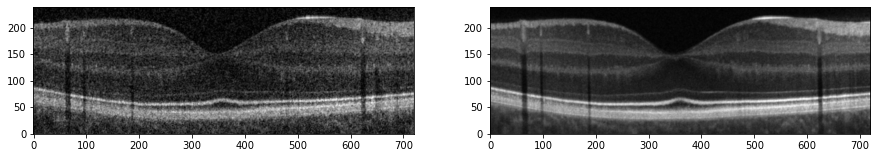

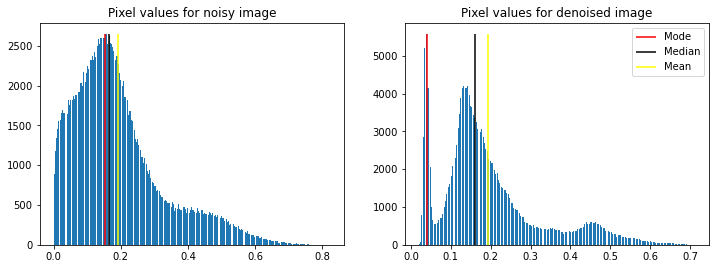

Mean square error between noisy image and denoised image: 0.002830120092699389
Structural similarity index between noisy image and denoised image 0.4821943840391292
----------------------------------------------------------------------------------------------------------------------------------
Standard deviation of pixel values in noisy image: 0.13628040978386483
Standard deviation of pixel values in denoised image: 0.12704407452723362
----------------------------------------------------------------------------------------------------------------------------------
Variance of Laplacian of noisy image 0.00619320751183851
Variance of Laplacian of denoised image 0.0005888604066572729


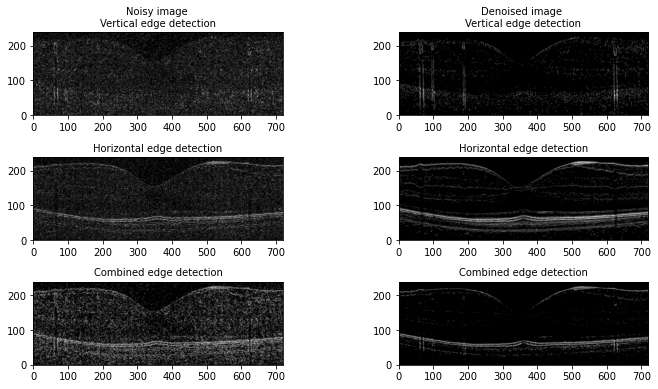

In [202]:
performance_metrics(image,GT)